In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

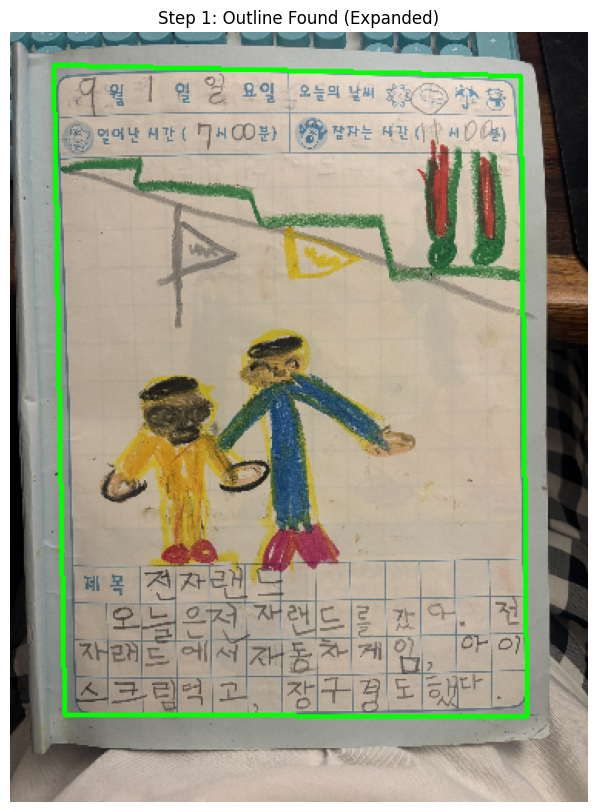

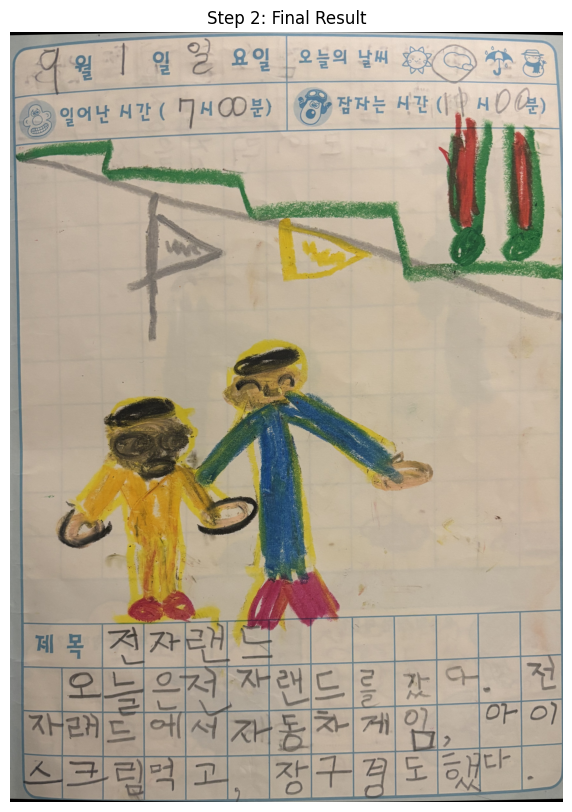

변환 성공


In [2]:
def imshow(title, image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.axis('off')
    plt.show()

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(image, M, (maxWidth, maxHeight))

def dewarp_book_page(img, curve_intensity=20):
    rows, cols = img.shape[:2]
    
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    dst = np.zeros((rows, cols, 3), dtype="uint8")

    alpha = np.radians(curve_intensity)
    r = cols / alpha 

    cy, cx = rows / 2, cols / 2
    y_indices, x_indices = np.indices((rows, cols))

    x_map = r * np.sin((x_indices - cx) / r) + cx
    y_map = (y_indices - cy) * (r / np.sqrt(np.square(r) - np.square(x_indices - cx))) + cy
    
    dst = cv2.remap(img, x_map.astype(np.float32), y_map.astype(np.float32), 
                    interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    
    return dst

def expand_contour(cnt, scale=1.03):
    M = cv2.moments(cnt)
    if M['m00'] == 0:
        return cnt
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])
    
    cnt_norm = cnt - [cx, cy]
    cnt_scaled = cnt_norm * scale
    cnt_new = cnt_scaled + [cx, cy]
    
    return cnt_new.astype(np.int32)

file_path = 'img4.jpg' 
image = cv2.imread(file_path)

if image is None:
    print("이미지를 찾을 수 없습니다.")
else:
    orig = image.copy()
    ratio = image.shape[0] / 500.0
    h = 500
    w = int(image.shape[1] / ratio)
    image_resized = cv2.resize(image, (w, h))

    gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    edged = cv2.Canny(gray, 50, 150)
    kernel = np.ones((5,5), np.uint8)
    edged = cv2.dilate(edged, kernel, iterations=1)
    
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

    screenCnt = None
    
    for c in cnts:
        peri = cv2.arcLength(c, True)
        for epsilon_val in [0.02, 0.05, 0.08]: 
            approx = cv2.approxPolyDP(c, epsilon_val * peri, True)
            if len(approx) == 4:
                screenCnt = approx
                break
        if screenCnt is not None:
            break

    if screenCnt is None and len(cnts) > 0:
        print("사각형을 찾지 못해 가장 큰 영역을 선택합니다.")
        rect = cv2.minAreaRect(cnts[0])
        box = cv2.boxPoints(rect)
        screenCnt = np.int0(box)

    if screenCnt is None:
        print("문서를 찾을 수 없습니다.")
    else:
        screenCnt = expand_contour(screenCnt, scale=1.03)

        cv2.drawContours(image_resized, [screenCnt], -1, (0, 255, 0), 2)
        imshow("Step 1: Outline Found (Expanded)", image_resized)

        warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
        final_result = dewarp_book_page(warped, curve_intensity=15)
        
        imshow("Step 2: Final Result", final_result)
        # cv2.imwrite('scan_result_final.jpg', final_result)
        print("변환 성공")

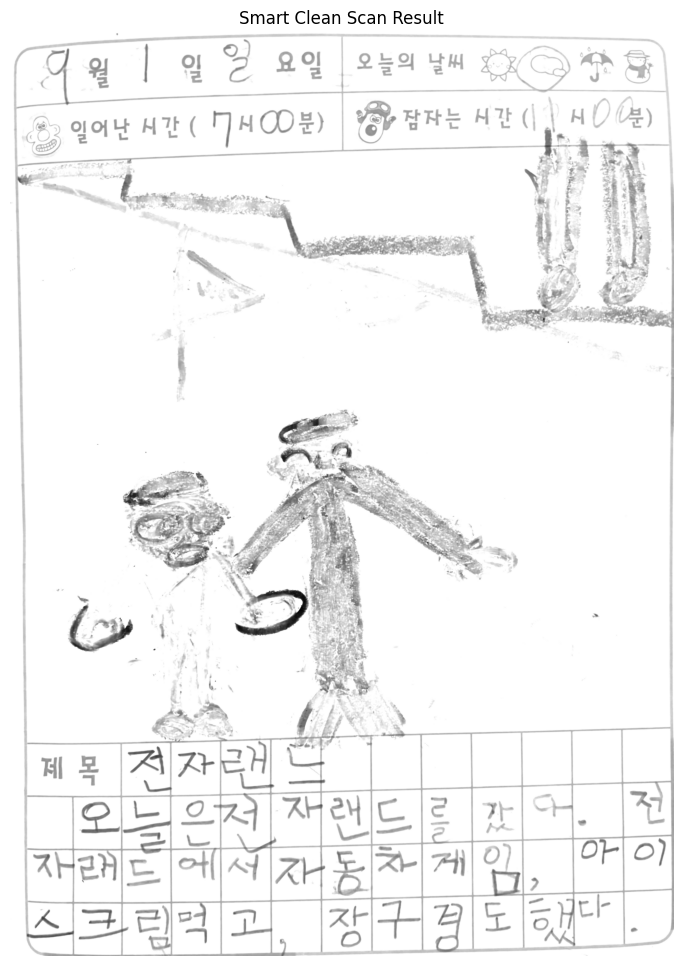

변환 완료! 'scan_result_smart.jpg'으로 저장되었습니다.


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 유틸리티 함수 정의 (이미지 표시, 좌표 정렬 등)
# ==========================================
def imshow(title, image):
    plt.figure(figsize=(12, 12))
    plt.title(title)
    if len(image.shape) == 3:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(image, M, (maxWidth, maxHeight))

def expand_contour(cnt, scale=1.03):
    M = cv2.moments(cnt)
    if M['m00'] == 0: return cnt
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])
    cnt_norm = cnt - [cx, cy]
    cnt_scaled = cnt_norm * scale
    cnt_new = cnt_scaled + [cx, cy]
    return cnt_new.astype(np.int32)

# ==========================================
# 2. 핵심 로직: 스스로 판단하여 깨끗하게 만들기
# ==========================================
def adaptive_cleanup(image):
    # (1) 그레이스케일 변환
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    # (2) 배경 평탄화 (밝게X -> 깨끗하게O)
    # 이미지를 크게 뭉개서 '배경(그림자)'만 추출합니다.
    # morphological close를 사용하여 글자는 무시하고 종이 질감만 따옵니다.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 40))
    bg_estimation = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    
    # 원본 이미지를 배경 이미지로 나눕니다. (Normalization)
    # 배경이 어두운 곳은 밝게 보정되어 전체적으로 톤이 균일해집니다.
    # scale=255로 하여 결과값이 0~255 사이로 오게 합니다.
    normalized = cv2.divide(gray, bg_estimation, scale=255)

    # (3) 노이즈 및 격자 뭉개기 (Bilateral Filter)
    # 글자 엣지는 살리고, 평평한 종이 부분의 자글자글한 노이즈만 뭉갭니다.
    smoothed = cv2.bilateralFilter(normalized, d=9, sigmaColor=75, sigmaSpace=75)

    # (4) 스스로 판단하기 (Otsu's Thresholding)
    # 이미지가 스스로 "어디까지가 글씨고 어디까지가 종이인지" 판단하는 알고리즘입니다.
    # otsu_thresh 변수에 그 기준값이 자동으로 담깁니다.
    otsu_thresh, _ = cv2.threshold(smoothed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # (5) Soft Cleaning (자연스러운 미백)
    # Otsu가 찾은 기준값보다 조금 더 여유를 둡니다 (+15 정도).
    # 이 기준보다 밝은 픽셀(종이, 연한 격자)은 하얗게 밀어버리고,
    # 어두운 픽셀(글씨)은 건드리지 않고 그대로 둡니다.
    cutoff = min(otsu_thresh + 15, 255) 
    
    # 임계값 적용: cutoff보다 밝으면 255(흰색), 아니면 원래 색 유지(TOZERO)
    # 이렇게 하면 글씨가 얇아지거나 날아가는 것을 방지할 수 있습니다.
    _, clean_result = cv2.threshold(smoothed, cutoff, 255, cv2.THRESH_TRUNC)
    
    # 마지막으로 명암비를 0~255로 꽉 채워줍니다 (글씨는 더 진하게, 배경은 더 하얗게)
    final_output = cv2.normalize(clean_result, None, 0, 255, cv2.NORM_MINMAX)

    return final_output

# ==========================================
# 3. 메인 실행 코드
# ==========================================
file_path = 'img4.jpg'  # 파일명을 여기에 넣으세요
image = cv2.imread(file_path)

if image is None:
    print(f"이미지를 찾을 수 없습니다: {file_path}")
else:
    orig = image.copy()
    ratio = image.shape[0] / 500.0
    h = 500
    w = int(image.shape[1] / ratio)
    image_resized = cv2.resize(image, (w, h))

    # --- 문서 찾기 (이전과 동일) ---
    gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 50, 150)
    kernel_edge = np.ones((5,5), np.uint8)
    edged = cv2.dilate(edged, kernel_edge, iterations=1)
    
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

    screenCnt = None
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            screenCnt = approx
            break

    # 못 찾으면 가장 큰 영역
    if screenCnt is None and len(cnts) > 0:
        rect = cv2.minAreaRect(cnts[0])
        box = cv2.boxPoints(rect)
        screenCnt = np.int0(box)

    if screenCnt is None:
        print("문서를 찾을 수 없습니다.")
    else:
        # --- 문서 펴기 ---
        screenCnt = expand_contour(screenCnt, scale=1.03)
        warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
        
        # --- [NEW] 스마트 클리닝 적용 ---
        # 여기서는 dewarp_book_page(굴곡 펴기)는 생략하고 
        # 바로 '깨끗하게 만드는' 로직에 집중했습니다. (필요 시 dewarp 추가 가능)
        final_result = adaptive_cleanup(warped)
        
        imshow("Smart Clean Scan Result", final_result)
        
        # 파일 저장
        save_name = 'scan_result_smart.jpg'
        cv2.imwrite(save_name, final_result)
        print(f"변환 완료! '{save_name}'으로 저장되었습니다.")